# Actor-Based Backtesting with Modern Portfolio Theory (MPT)

This notebook builds upon the previous actor-based backtest but replaces the simple 1/N (equal weight) allocation with **Mean-Variance Optimization** (MPT).

### Objectives:
- Identify active trading signals using RSI, MACD, and Golden Crossover.
- Periodically optimize the portfolio weights of the 'signaled' assets to maximize the **Sharpe Ratio**.
- Use the `trade-engine` to execute these target weight rebalances.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import uuid
from sqlalchemy import create_engine, StaticPool
from scipy.optimize import minimize

# 1. Setup Engine Paths
engine_root = os.path.abspath("../another_testing_engine/trade-engine/trade-engine")
if engine_root not in sys.path:
    sys.path.append(engine_root)

from tradeengine.actors.memory import MemPortfolioActor
from tradeengine.actors.sql import SQLOrderbookActor
from tradeengine.backtest import BacktestStrategy
from tradeengine.dto import Asset

print("Engine components and Optimizer imported successfully.")

Engine components and Optimizer imported successfully.


## Data Loading
We load 30 assets to provide a sufficiently diverse universe for optimization.

In [2]:
data_dir = "../dataset/cleaned"
asset_files = sorted([f for f in os.listdir(data_dir) if f.startswith("Asset_") and f.endswith(".csv")])[:30]
assets = [f.split(".")[0] for f in asset_files]

dfs = {}
for a, f in zip(assets, asset_files):
    path = os.path.join(data_dir, f)
    df = pd.read_csv(path, parse_dates=True, index_col="Date")
    dfs[a] = df.sort_index()

print(f"Loaded {len(dfs)} assets for the MPT universe.")

Loaded 30 assets for the MPT universe.


## Signal Logic & Returns Calculation
We keep the same indicator signals but now we also calculate **daily returns** to feed the optimizer.

In [3]:
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

signals_raw = {}
all_returns = {}

for a, df in dfs.items():
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()
    df['RSI'] = calculate_rsi(df['Close'])
    df['MACD'], df['Signal'] = calculate_macd(df['Close'])
    df['SMA50'] = df['Close'].rolling(window=50).mean()
    df['SMA200'] = df['Close'].rolling(window=200).mean()
    
    # Core Signals
    df['Raw_Buy'] = (df['SMA50'] > df['SMA200']) | ((df['RSI'] < 30) & (df['MACD'] > df['Signal']))
    df['Raw_Sell'] = (df['RSI'] > 70) | ((df['SMA50'] < df['SMA200']) & (df['MACD'] < df['Signal']))
    
    signals_raw[a] = df
    all_returns[a] = df['Returns']

# Combined returns matrix for optimization
returns_matrix = pd.DataFrame(all_returns)
print("Signals and returns matrix prepared.")

Signals and returns matrix prepared.


## MPT Optimization Function
We define a function that takes a lookback of returns and returns the weights that maximize the Sharpe Ratio.

In [4]:
def get_optimal_weights(candidates, current_date, lookback_days=126):
    if not candidates:
        return {}
    
    # Filter returns for lookback and candidates
    start_date = current_date - timedelta(days=lookback_days)
    history = returns_matrix.loc[start_date:current_date, list(candidates)].dropna(how='all').fillna(0)
    
    if len(history) < 20: # Minimum data check
        return {a: 1.0/len(candidates) for a in candidates}
    
    mean_returns = history.mean() * 252
    cov_matrix = history.cov() * 252
    
    def objective(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return - (port_return - 0.02) / (port_vol + 1e-9) # Maximize Sharpe (Negative for minimization)

    n = len(candidates)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
    bounds = [(0, 0.2) for _ in range(n)] # Limit concentration to 20% max per asset
    initial_guess = [1.0/n] * n
    
    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return dict(zip(candidates, result.x))
    else:
        return {a: 1.0/n for a in candidates} # Fallback to equal weight

## Strategy Loop with MPT Rebalancing
Instead of static 1/N, we re-run optimization whenever the set of signaled assets changes or monthly.

In [5]:
active_set = set()
all_dates = sorted(returns_matrix.index)
final_signals = {a: {} for a in assets}
last_optimization_date = None

print("Generating MPT-optimized signals. This involves repeated optimizations...")

for i, t in enumerate(all_dates):
    changed = False
    
    # 1. Update active set based on entry/exit signals
    for a in assets:
        row = signals_raw[a].loc[t] if t in signals_raw[a].index else None
        if row is None: continue
        
        if row['Raw_Sell'] and a in active_set:
            active_set.remove(a)
            final_signals[a][t] = {'CloseOrder': {}}
            changed = True
        elif row['Raw_Buy'] and a not in active_set:
            if len(active_set) < 20: # Keep the universe size manageable
                active_set.add(a)
                changed = True

    # 2. Re-optimize weights if set changed or month passed
    is_new_month = (last_optimization_date is None or t.month != last_optimization_date.month)
    if (changed or is_new_month) and active_set:
        weights = get_optimal_weights(active_set, t)
        for a, w in weights.items():
            final_signals[a][t] = {'TargetWeightOrder': {'size': float(w)}}
        last_optimization_date = t

# Format for engine
formatted_signals = {}
for a, sig_dict in final_signals.items():
    s = pd.Series(sig_dict)
    s.index = pd.to_datetime(s.index)
    formatted_signals[a] = s if not s.empty else pd.Series(dtype=object)

print("Signal generation with MPT weights complete.")

Generating MPT-optimized signals. This involves repeated optimizations...
Signal generation with MPT weights complete.


## Execute MPT Backtest

In [6]:
fund_value = 1_000_000.0
portfolio_actor = MemPortfolioActor.start(funding=fund_value)

db_engine = create_engine('sqlite://', echo=False, connect_args={'check_same_thread': False}, poolclass=StaticPool)
orderbook_actor = SQLOrderbookActor.start(
    portfolio_actor,
    db_engine,
    strategy_id=str(uuid.uuid4())
)

quote_frames = {a: dfs[a][['Open', 'High', 'Low', 'Close']] for a in assets}

print("Starting MPT backtest...")
bt_strategy = BacktestStrategy(orderbook_actor, portfolio_actor, quote_frames)
result_mpt = bt_strategy.run_backtest(formatted_signals)
print("Backtest finished.")

Starting MPT backtest...


100%|██████████| 2511/2511 [13:05<00:00,  3.20it/s]


Backtest finished.


## Performance Comparison
Plot the equity curve of the MPT-managed portfolio.

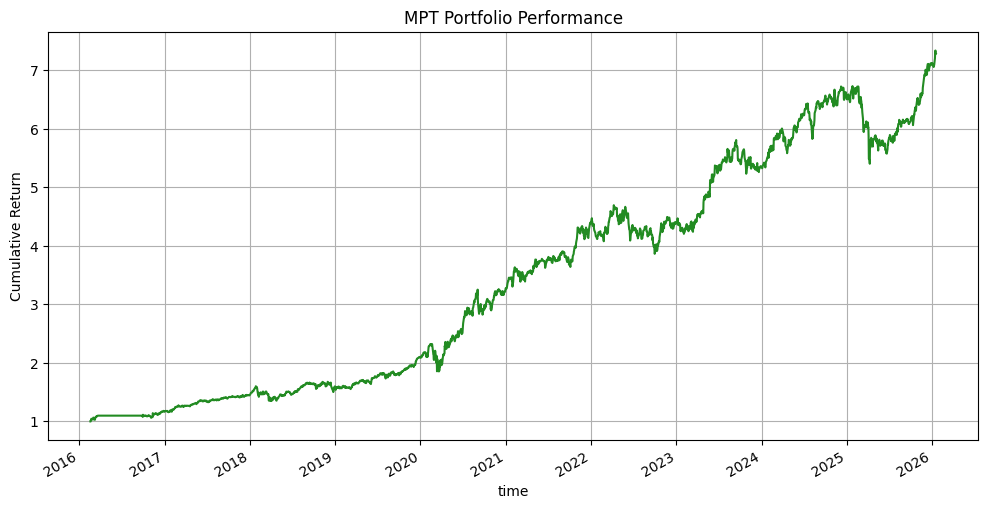

MPT Final Portfolio Value: 7280227.637961691
MPT Total Return: 628.022763796172 %


In [7]:
import matplotlib.pyplot as plt

perf = result_mpt.porfolio_performance
perf['performance'].plot(figsize=(12, 6), color='forestgreen', title="MPT Portfolio Performance")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

print("MPT Final Portfolio Value:", perf['value'].iloc[-1])
print("MPT Total Return:", (perf['performance'].iloc[-1] - 1) * 100, "%")